In [14]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf

from PIL import Image
import cv2

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


import xgboost
import warnings
warnings.filterwarnings("ignore")


In [23]:
base_dir = '/kaggle/input/brain-tumor-classification-mri'
TRAINING_DIR = os.path.join(base_dir, 'Training')
TESTING_DIR = os.path.join(base_dir, 'Testing')
classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

# Step 1. Collect all image paths and labels
all_images = []
all_labels = []
for cls in classes:
    for folder in [TRAINING_DIR, TESTING_DIR]:
        class_dir = os.path.join(folder, cls)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_images.append(os.path.join(class_dir, img_file))
                    all_labels.append(cls)

from sklearn.model_selection import train_test_split

# Step 1: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=all_labels
)

# Step 2: 5% val, 15% test from the 20% temp
# 5% out of 20% is 0.25 (so test_size=0.75 means 15% test, 0.25 means 5% val)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.75,  # 75% of 20% = 15% of total for test, 25% of 20% = 5% of total for val
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)}")
print(f"Val: {len(X_val)}")
print(f"Test: {len(X_test)}")



Train: 2611
Val: 163
Test: 490


In [24]:
# Step 3: Define image loading function
import cv2
import numpy as np

IMG_SIZE = (224, 224)
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images)

In [25]:
# Step 4: Load images for each split
train_images = load_images(X_train)
val_images = load_images(X_val)
test_images = load_images(X_test)

print("Loaded images:")
print("  Train:", train_images.shape)
print("  Val:", val_images.shape)
print("  Test:", test_images.shape)

Loaded images:
  Train: (2611, 224, 224, 3)
  Val: (163, 224, 224, 3)
  Test: (490, 224, 224, 3)


In [26]:
# Step 5: Feature extraction with VGG16
import tensorflow as tf

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet'
)

# Extract features for each split
train_features = base_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)
del train_images

val_features = base_model.predict(val_images)
val_features = val_features.reshape(val_features.shape[0], -1)
del val_images

test_features = base_model.predict(test_images)
test_features = test_features.reshape(test_features.shape[0], -1)
del test_images

print("Feature shapes:")
print("  Train:", train_features.shape)
print("  Val:", val_features.shape)
print("  Test:", test_features.shape)

82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 759ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 604ms/step
Feature shapes:
  Train: (2611, 25088)
  Val: (163, 25088)
  Test: (490, 25088)


In [27]:
# Step 6: Encode labels for ML classifiers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

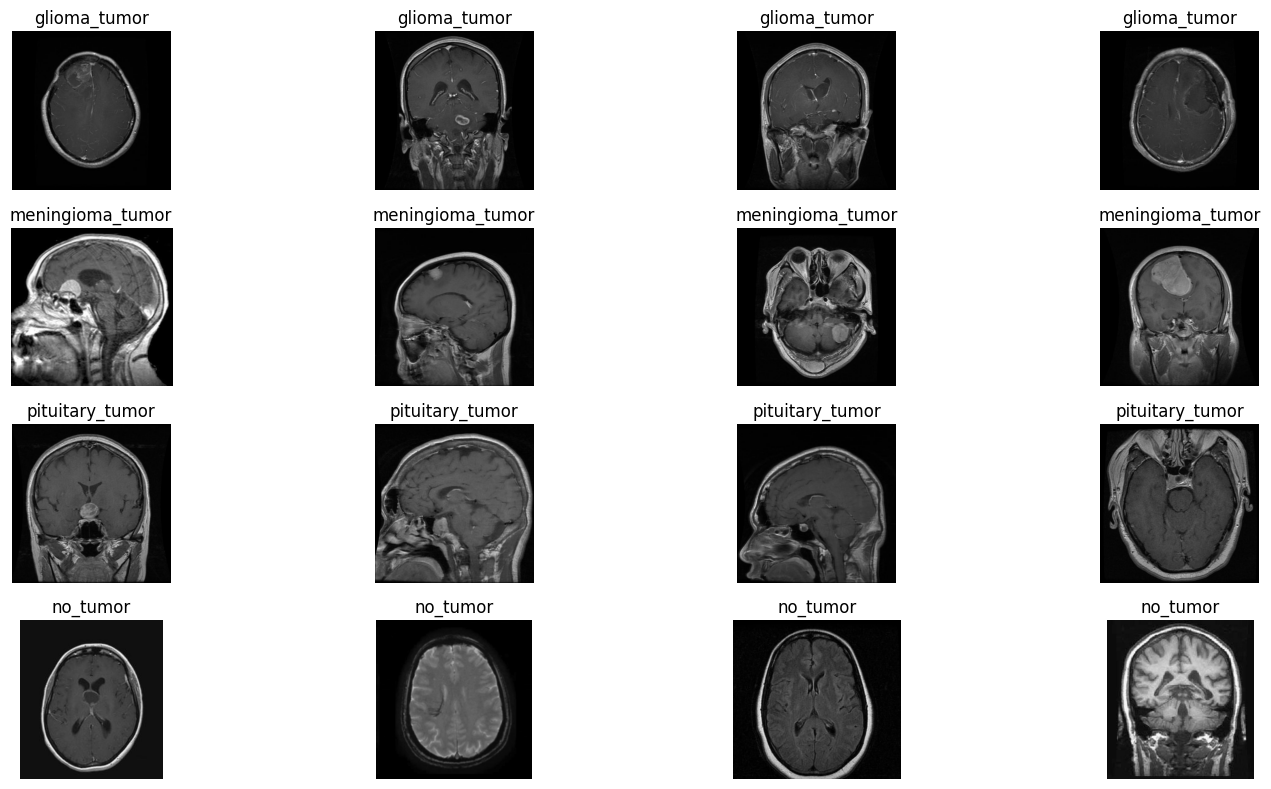

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

# Show 4 images per class from the training set
plt.figure(figsize=(16, 8))
for idx, cls in enumerate(classes):
    # Get indices of images in this class
    indices = [i for i, label in enumerate(y_train) if label == cls]
    # Show up to 4 images
    for j in range(4):
        if j < len(indices):
            img_path = X_train[indices[j]]
            img = Image.open(img_path)
            plt.subplot(len(classes), 4, idx*4 + j + 1)
            plt.imshow(img)
            plt.title(f"{cls}")
            plt.axis("off")
plt.tight_layout()
plt.show()


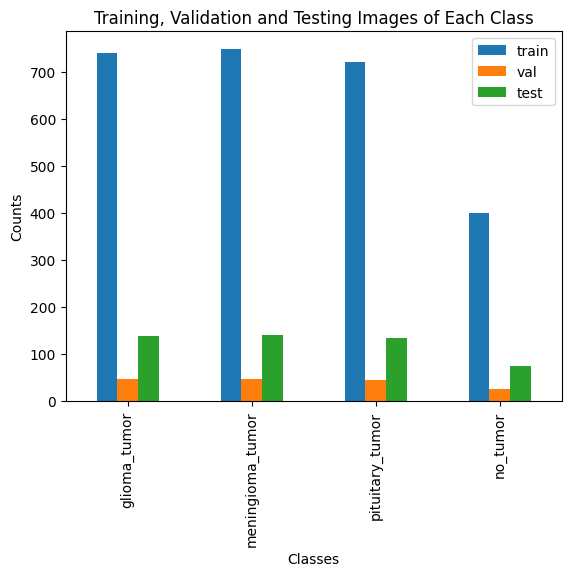

In [29]:
import pandas as pd

# Count samples per class for each split
train_counts = [sum([1 for label in y_train if label == cls]) for cls in classes]
val_counts = [sum([1 for label in y_val if label == cls]) for cls in classes]
test_counts = [sum([1 for label in y_test if label == cls]) for cls in classes]

# Create DataFrame
data_count = pd.DataFrame({
    'categories': classes,
    'train': train_counts,
    'val': val_counts,
    'test': test_counts
})

# Plot
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Class")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()


In [31]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [32]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [41]:
def load_images(image_paths, labels):
    """Load images and filter out invalid files while keeping labels aligned"""
    valid_images = []
    valid_labels = []
    for path, label in zip(image_paths, labels):
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            valid_images.append(img)
            valid_labels.append(label)
    return np.array(valid_images), np.array(valid_labels)

# Load images and filter invalid files
train_images, y_train_filtered = load_images(X_train, y_train)
val_images, y_val_filtered = load_images(X_val, y_val)
test_images, y_test_filtered = load_images(X_test, y_test)

print("Filtered dataset sizes:")
print(f"  Train: {len(train_images)} images, {len(y_train_filtered)} labels")
print(f"  Val: {len(val_images)} images, {len(y_val_filtered)} labels")
print(f"  Test: {len(test_images)} images, {len(y_test_filtered)} labels")


Filtered dataset sizes:
  Train: 2611 images, 2611 labels
  Val: 163 images, 163 labels
  Test: 490 images, 490 labels


In [42]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(y_train_filtered)
val_labels_encoded = le.transform(y_val_filtered)
test_labels_encoded = le.transform(y_test_filtered)


In [43]:
# Extract VGG16 features
train_features = base_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)
del train_images  # Free memory

val_features = base_model.predict(val_images)
val_features = val_features.reshape(val_features.shape[0], -1)
del val_images

test_features = base_model.predict(test_images)
test_features = test_features.reshape(test_features.shape[0], -1)
del test_images


82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step


In [44]:
# Step 1: Verify feature and label dimensions
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels_encoded.shape)
assert train_features.shape[0] == train_labels_encoded.shape[0], "Train data/label mismatch!"

print("Val features shape:", val_features.shape)
print("Val labels shape:", val_labels_encoded.shape)
assert val_features.shape[0] == val_labels_encoded.shape[0], "Val data/label mismatch!"

# Step 2: Encode labels correctly (do this once)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(classes)  # Fit on all possible classes

train_labels_encoded = le.transform(y_train)
val_labels_encoded = le.transform(y_val)
test_labels_encoded = le.transform(y_test)

Train features shape: (2611, 25088)
Train labels shape: (2611,)
Val features shape: (163, 25088)
Val labels shape: (163,)


In [48]:
from xgboost import XGBClassifier

# Initialize model with parameters for multi-class classification
model = XGBClassifier(
    objective='multi:softprob',  # For 4 tumor classes
    num_class=4,                 # Number of classes in your dataset
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train with early stopping
model.fit(
    train_features, 
    train_labels_encoded,
    eval_metric=["merror"], 
    eval_set=[(train_features, train_labels_encoded), (val_features, val_labels_encoded)],
    early_stopping_rounds=20,  # Added here
    verbose=True)

[0]	validation_0-merror:0.12562	validation_1-merror:0.26380


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [49]:
results = model.evals_result()


In [50]:
train_error = results['validation_0']['merror']
train_acc = [1.0 - i for i in train_error]

val_error = results['validation_1']['merror']
val_acc = [1.0 - i for i in val_error]


In [53]:
# For XGBoost ≥ 1.3+, use best_iteration instead of best_ntree_limit
if hasattr(model, 'best_iteration'):
    print(f"Best iteration: {model.best_iteration}")
    print(f"Best ntree limit (if needed): {model.best_iteration + 1}")  # +1 for 1-based indexing
else:
    print("Early stopping didn't trigger or model wasn't trained with validation data")




Best iteration: 0
Best ntree limit (if needed): 1


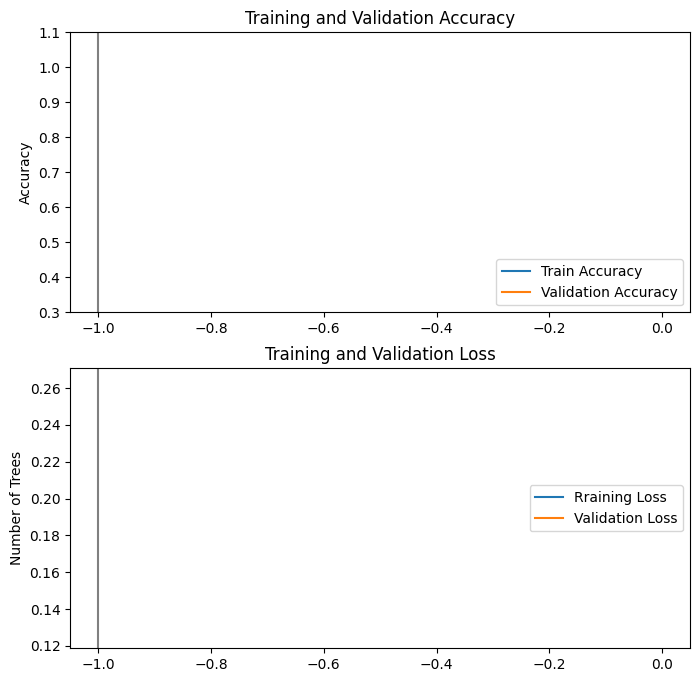

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1.1])
plt.axvline(model.best_iteration-1, color="gray", label="Optimal tree number")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_error, label='Rraining Loss')
plt.plot(val_error, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.axvline(model.best_iteration-1, color="gray", label="Optimal tree number")
plt.ylabel('merror')
plt.ylabel('Number of Trees')

plt.show()


In [56]:
train_predictions = model.predict(train_features)
val_predictions = model.predict(val_features)

print ("Training Accuracy = ", accuracy_score(train_labels_encoded, train_predictions))
print ("Validation Accuracy = ", accuracy_score(val_labels_encoded, val_predictions))


Training Accuracy =  0.8743776330907698
Validation Accuracy =  0.7361963190184049


In [60]:
model2 = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=model.best_iteration)

model2.fit(
    train_features, 
    train_labels_encoded,  
    eval_metric=["merror"], 
    eval_set=eval_set, 
    verbose=True
)


NameError: name 'model' is not defined

In [ ]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")

CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)
    
CLASSES

In [ ]:
test_features = base_model.predict(test_images)
test_features = test_features.reshape(test_features.shape[0], -1)
del(test_images)


In [ ]:
predictions = model.predict(test_features)


In [ ]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(test_labels_encoded, predictions))
print('Precision: \t\t', precision_score(test_labels_encoded, predictions, average='weighted'))
print('Recall: \t\t', recall_score(test_labels_encoded, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(test_labels_encoded, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=test_labels_encoded, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.xaxis.set_ticklabels(CLASSES); 
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()


In [ ]:
os.chdir('/kaggle/working')
model.save_model('xbg_model.json')